In [2]:
import sys; sys.path.append("../../../utility_scripts/")
from infercnv_utils import *
# make this notebook work better with Scanpy
import warnings; warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import infercnvpy as cnv

In [3]:
sc.set_figure_params(transparent=True, dpi_save=400)
sc.settings.figdir = "infercnv/figures/"

In [4]:
sample_order = ["HTA11_06134","HTA11_07663","HTA11_08622","HTA11_01938","HTA11_07862","HTA11_10711","PAT73458","PAT71397","PAT71662","PAT73899","PAT74143"]

---
# Read in ST CNV samples (all patients)

In [5]:
sample_key = pd.read_csv("../../resources/visium_sample_key.csv", index_col=0)

In [6]:
cmap_dict = {
    # Tumor Type
    'SSL/HP':"#c4a4e1",'MSI':"#7a4fa3",'MSS':"#ffc101",'TA/TVA':"#fee799",'NL':"#1f77b4",
    # Tumor Location
    "Cecum":"#1f4e79","Ascending":"#2e74b7","Hepatic Flexure":"#bdd6ef","Transverse":"#ff717a","Descending":"#fe0001","Sigmoid":"#c00101",
    # this one's global
    "nan":"#ffffff",
    # These are black and white for T and F
    "T":"#000000","F":"#ffffff",
}
stage_colordict = dict(zip(["AD","I","II","III/IV"], sns.color_palette("Reds", len(["AD","I","II","III/IV"])).as_hex()))
grade_colordict = dict(zip(["G1","G2","G3"], sns.color_palette("Reds", len(["G1","G2","G3"])).as_hex()))
cmap_dict = {**cmap_dict, **stage_colordict, **grade_colordict}

In [7]:
patient_colordict = dict(zip(sample_key.patient_name, [cmap_dict[x] for x in sample_key.tumor_type]))

In [7]:
outs = []
for pat in sample_key.patient_name.unique():
    print(pat)
    a_comb = load_cnv(pat, sample_key=sample_key, CNV_group="patient_name")
    outs.append(a_comb)

SR00001
Read adata from datasets/8578_4_SR00001_master.h5ad
HTA11_01938
Read adata from datasets/7319_4_HTA11_01938_master.h5ad
HTA11_07862
Read adata from datasets/8270_1_HTA11_07862_master.h5ad
HTA11_10711
Read adata from datasets/8270_2_HTA11_10711_master.h5ad
PAT71397
Read adata from datasets/6723_4_WD86055_master.h5ad
Read adata from datasets/6723_1_WD86056_master.h5ad
Read adata from datasets/6723_2_WD86056_master.h5ad
Read adata from datasets/6723_3_WD86056_master.h5ad
PAT05785
Read adata from datasets/7794_2_WD33468_master.h5ad
PAT06439
Read adata from datasets/8578_1_WD33469_master.h5ad
PAT15211
Read adata from datasets/8578_1_WD33473_master.h5ad
PAT30884
Read adata from datasets/8270_6_WD84602_master.h5ad
Read adata from datasets/8270_7_WD84602_master.h5ad
PAT59600
Read adata from datasets/8270_9_WD84594_master.h5ad
Read adata from datasets/8578_2_WD84594_master.h5ad
PAT59667
Read adata from datasets/8270_8_WD84596_master.h5ad
Read adata from datasets/8578_3_WD84596_master.h5

In [8]:
for out in outs:
    out.obs.cnv_leiden = out.obs.cnv_leiden.astype(str)
    out.obs.cnv_leiden = out.obs.cnv_leiden.astype("category")
    out.obsm["X_cnv"], out.uns["cnv"] = remap_cnv(
        out.obsm["X_cnv"],
        out.uns["cnv"],
        [17,10,9,6,7,8,7,5,6,6,9,9,2,5,5,7,9,2,12,4,2,3],
    )

chr1: orig. size = 190 - taking 3 off the top and reshaping by 11
chr2: orig. size = 118 - taking 8 off the top and reshaping by 11
chr3: orig. size = 100 - taking 1 off the top and reshaping by 11
chr4: orig. size = 70 - taking 4 off the top and reshaping by 11
chr5: orig. size = 83 - taking 6 off the top and reshaping by 11
chr6: orig. size = 97 - taking 1 off the top and reshaping by 12
chr7: orig. size = 89 - taking 5 off the top and reshaping by 12
chr8: orig. size = 62 - taking 2 off the top and reshaping by 12
chr9: orig. size = 73 - taking 1 off the top and reshaping by 12
chr10: orig. size = 69 - taking 3 off the top and reshaping by 11
chr11: orig. size = 118 - taking 1 off the top and reshaping by 13
chr12: orig. size = 96 - taking 6 off the top and reshaping by 10
chr13: orig. size = 30 - taking 0 off the top and reshaping by 15
chr14: orig. size = 68 - taking 3 off the top and reshaping by 13
chr15: orig. size = 55 - taking 0 off the top and reshaping by 11
chr16: orig. si

In [9]:
%%time
# concatenate anndata objects
a_comb = outs[0].concatenate(
    outs[1:],
    join="outer",
    batch_categories=list(sample_key.index),
    fill_value=0,
)
#del a_comb.obsm
del a_comb.var

# add cnv genome partitions
a_comb.uns["cnv"] = outs[0].uns["cnv"]

# uniqueify clone names
a_comb.obs["CNV Clone"] = a_comb.obs["Patient"] + " " + a_comb.obs["CNV Clone"]

CPU times: user 14 s, sys: 1.41 s, total: 15.4 s
Wall time: 15.4 s


In [10]:
# create patient colormap corresponding to tumor type
a_comb.obs.Patient = a_comb.obs.Patient.astype("category")
a_comb.uns["Patient_colors"] = [patient_colordict[x] for x in a_comb.obs.Patient.cat.categories]

In [27]:
a_comb.obs["Tumor Type"] = a_comb.obs["Tumor Type"].astype("category")
a_comb.uns["Tumor Type_colors"] = [cmap_dict[x] for x in a_comb.obs["Tumor Type"].cat.categories]

In [11]:
# subset to major clones
a_comb_major = a_comb[
    ~(a_comb.obs["CNV Clone"].str.contains(" E")|a_comb.obs["CNV Clone"].str.contains(" S")),
    :
].copy()

... storing 'Sample' as categorical
... storing 'Block ID' as categorical
... storing 'Tumor Type' as categorical
... storing 'Tumor Location' as categorical
... storing 'Gender' as categorical
... storing 'Ethnicity' as categorical
... storing 'pathology_annotation' as categorical
... storing 'Tumor Stage' as categorical
... storing 'Tumor Grade' as categorical
... storing 'cnv_leiden' as categorical
... storing 'CNV Clone' as categorical
... storing 'MILWRM Domain' as categorical
... storing 'refNMF-MxIF MILWRM Domain' as categorical
... storing 'LCM_ROI' as categorical


         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: HTA11_01938, HTA11_06134, HTA11_07663, etc.
var_group_labels: chr1, chr2, chr3, etc.


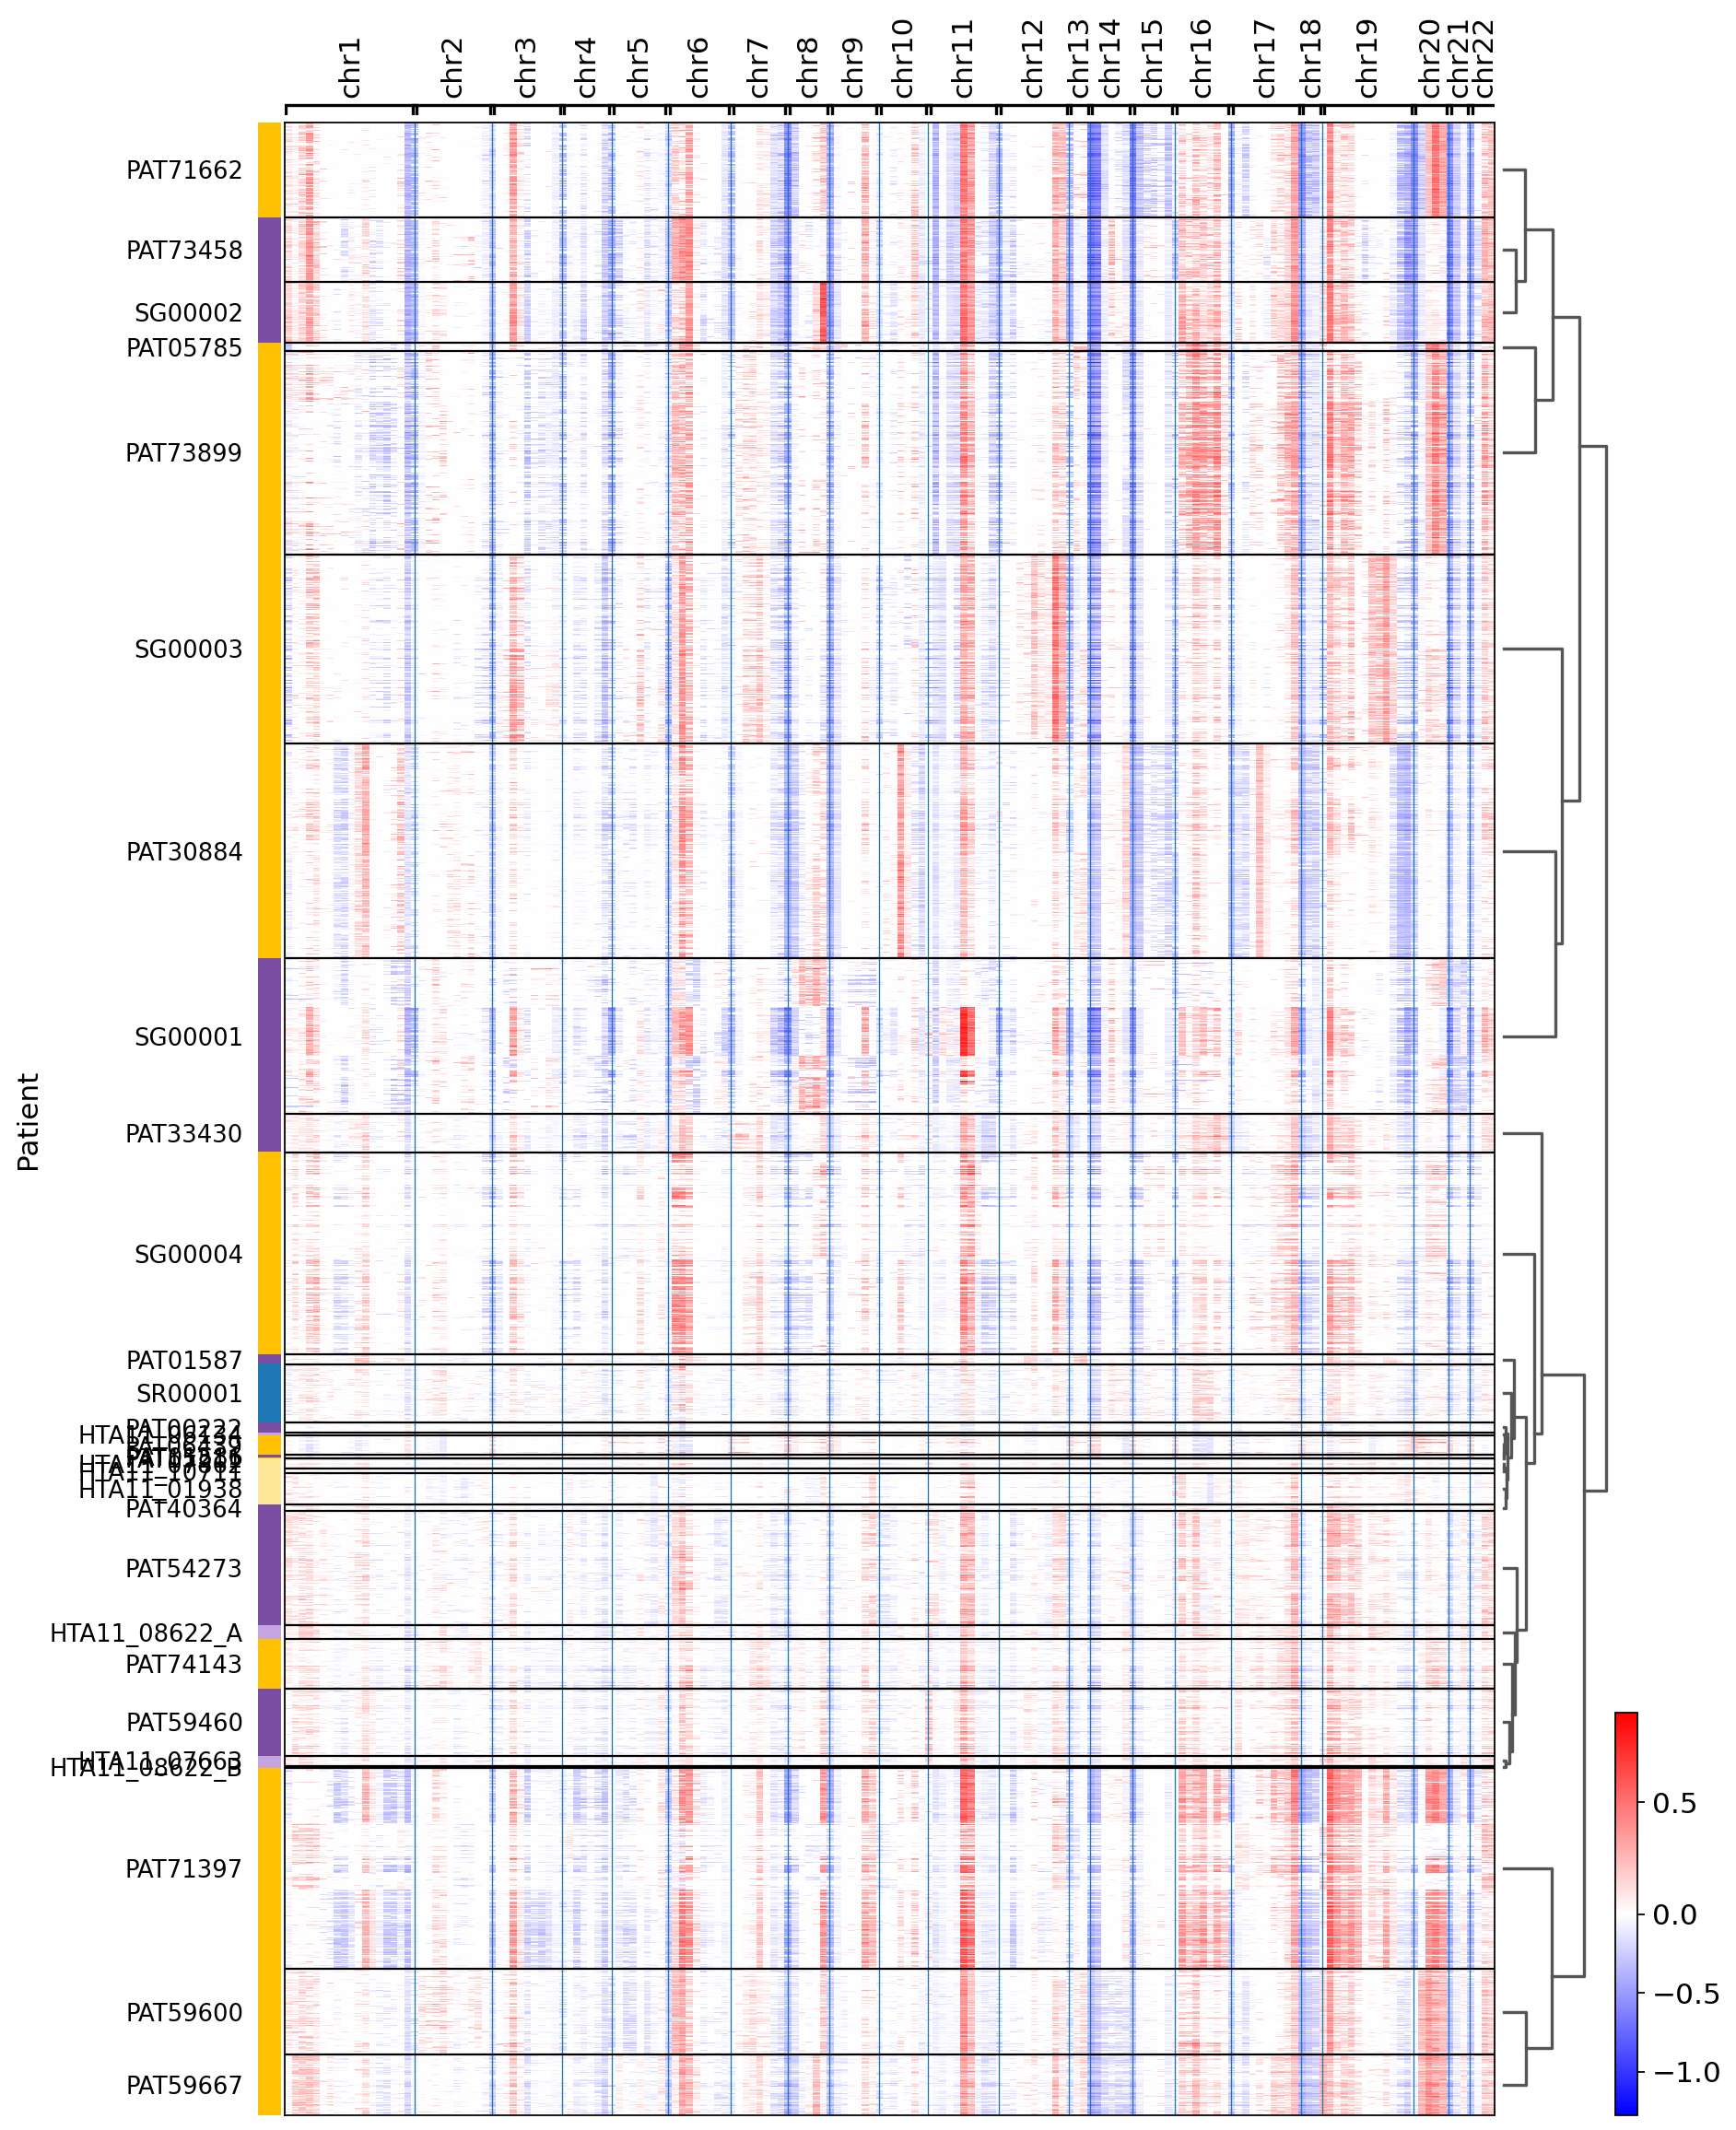

In [12]:
cnv.pl.chromosome_heatmap(
    a_comb_major,
    groupby="Patient",
    save="_ST_patient_all_remapped.png",
    dendrogram=True,
    figsize=(12,18),
)

In [14]:
%%time
cnv.tl.pca(a_comb_major, n_comps = 50)
cnv.pp.neighbors(a_comb_major, n_neighbors=int(np.sqrt(a_comb_major.n_obs)))
cnv.tl.leiden(a_comb_major, resolution=0.8)

CPU times: user 9min 44s, sys: 1min 30s, total: 11min 14s
Wall time: 1min 46s


In [19]:
a_comb_major.obsm["X_pca"] = a_comb_major.obsm["X_cnv_pca"]

In [38]:
import colorcet as cc
a_comb_major.uns["Patient_colors"] = sns.color_palette(cc.glasbey, n_colors=len(a_comb_major.obs.Patient.cat.categories)).as_hex()

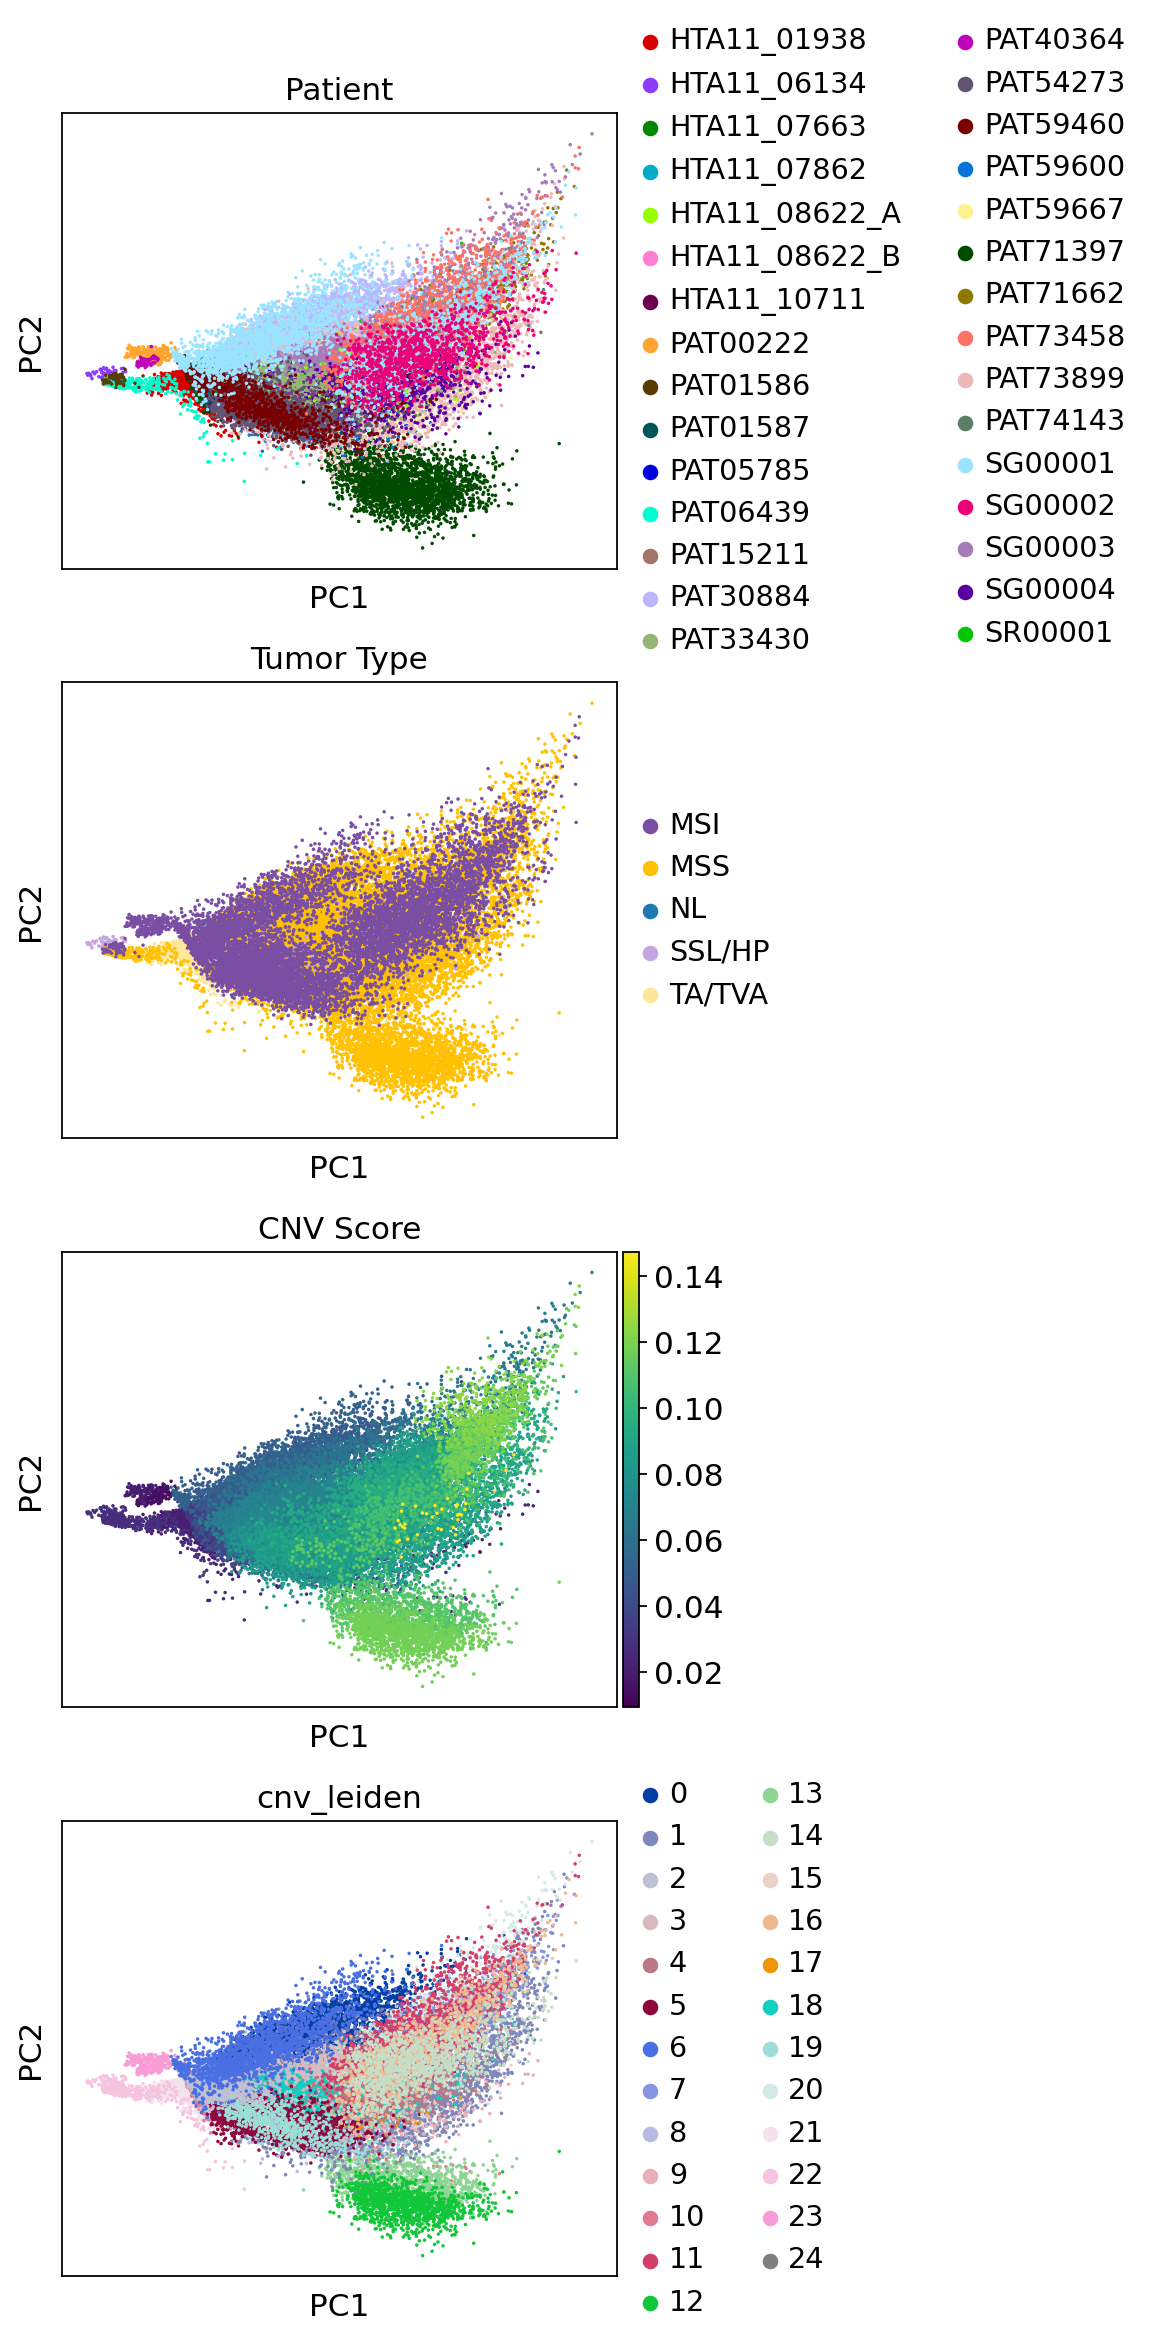

In [41]:
sc.pl.pca(a_comb_major, color=["Patient","Tumor Type", "CNV Score", "cnv_leiden"], components=['1,2'], cmap="viridis", ncols=1, size=10)

In [42]:
%time cnv.tl.umap(a_comb_major)

CPU times: user 2min 44s, sys: 6min 7s, total: 8min 52s
Wall time: 39.5 s


In [46]:
pat_colordict = dict(zip(a_comb_major.obs.Patient.cat.categories, a_comb_major.uns["Patient_colors"]))

In [51]:
for pat in a_comb_major.obs.Patient.cat.categories:
    print(pat)
    a_comb_major.obs[pat] = np.nan
    a_comb_major.obs.loc[a_comb_major.obs.Patient==pat, pat] = pat
    a_comb_major.obs[pat] = a_comb_major.obs[pat].astype("category")
    a_comb_major.uns["{}_colors".format(pat)] = [patient_colordict[x] for x in a_comb_major.obs[pat].cat.categories]

HTA11_01938
HTA11_06134
HTA11_07663
HTA11_07862
HTA11_08622_A
HTA11_08622_B
HTA11_10711
PAT00222
PAT01586
PAT01587
PAT05785
PAT06439
PAT15211
PAT30884
PAT33430
PAT40364
PAT54273
PAT59460
PAT59600
PAT59667
PAT71397
PAT71662
PAT73458
PAT73899
PAT74143
SG00001
SG00002
SG00003
SG00004
SR00001


In [64]:
a_comb_major.obs["PAT71397"] = a_comb_major.obs["Tumor Type"].values
a_comb_major.obs.loc[a_comb_major.obs.Patient!="PAT71397", "PAT71397"] = np.nan

In [65]:
a_comb_major.obs["PAT71397"] = a_comb_major.obs["PAT71397"].astype("category")
a_comb_major.uns["PAT71397_colors"] = [cmap_dict[x] for x in a_comb_major.obs["PAT71397"].cat.categories]

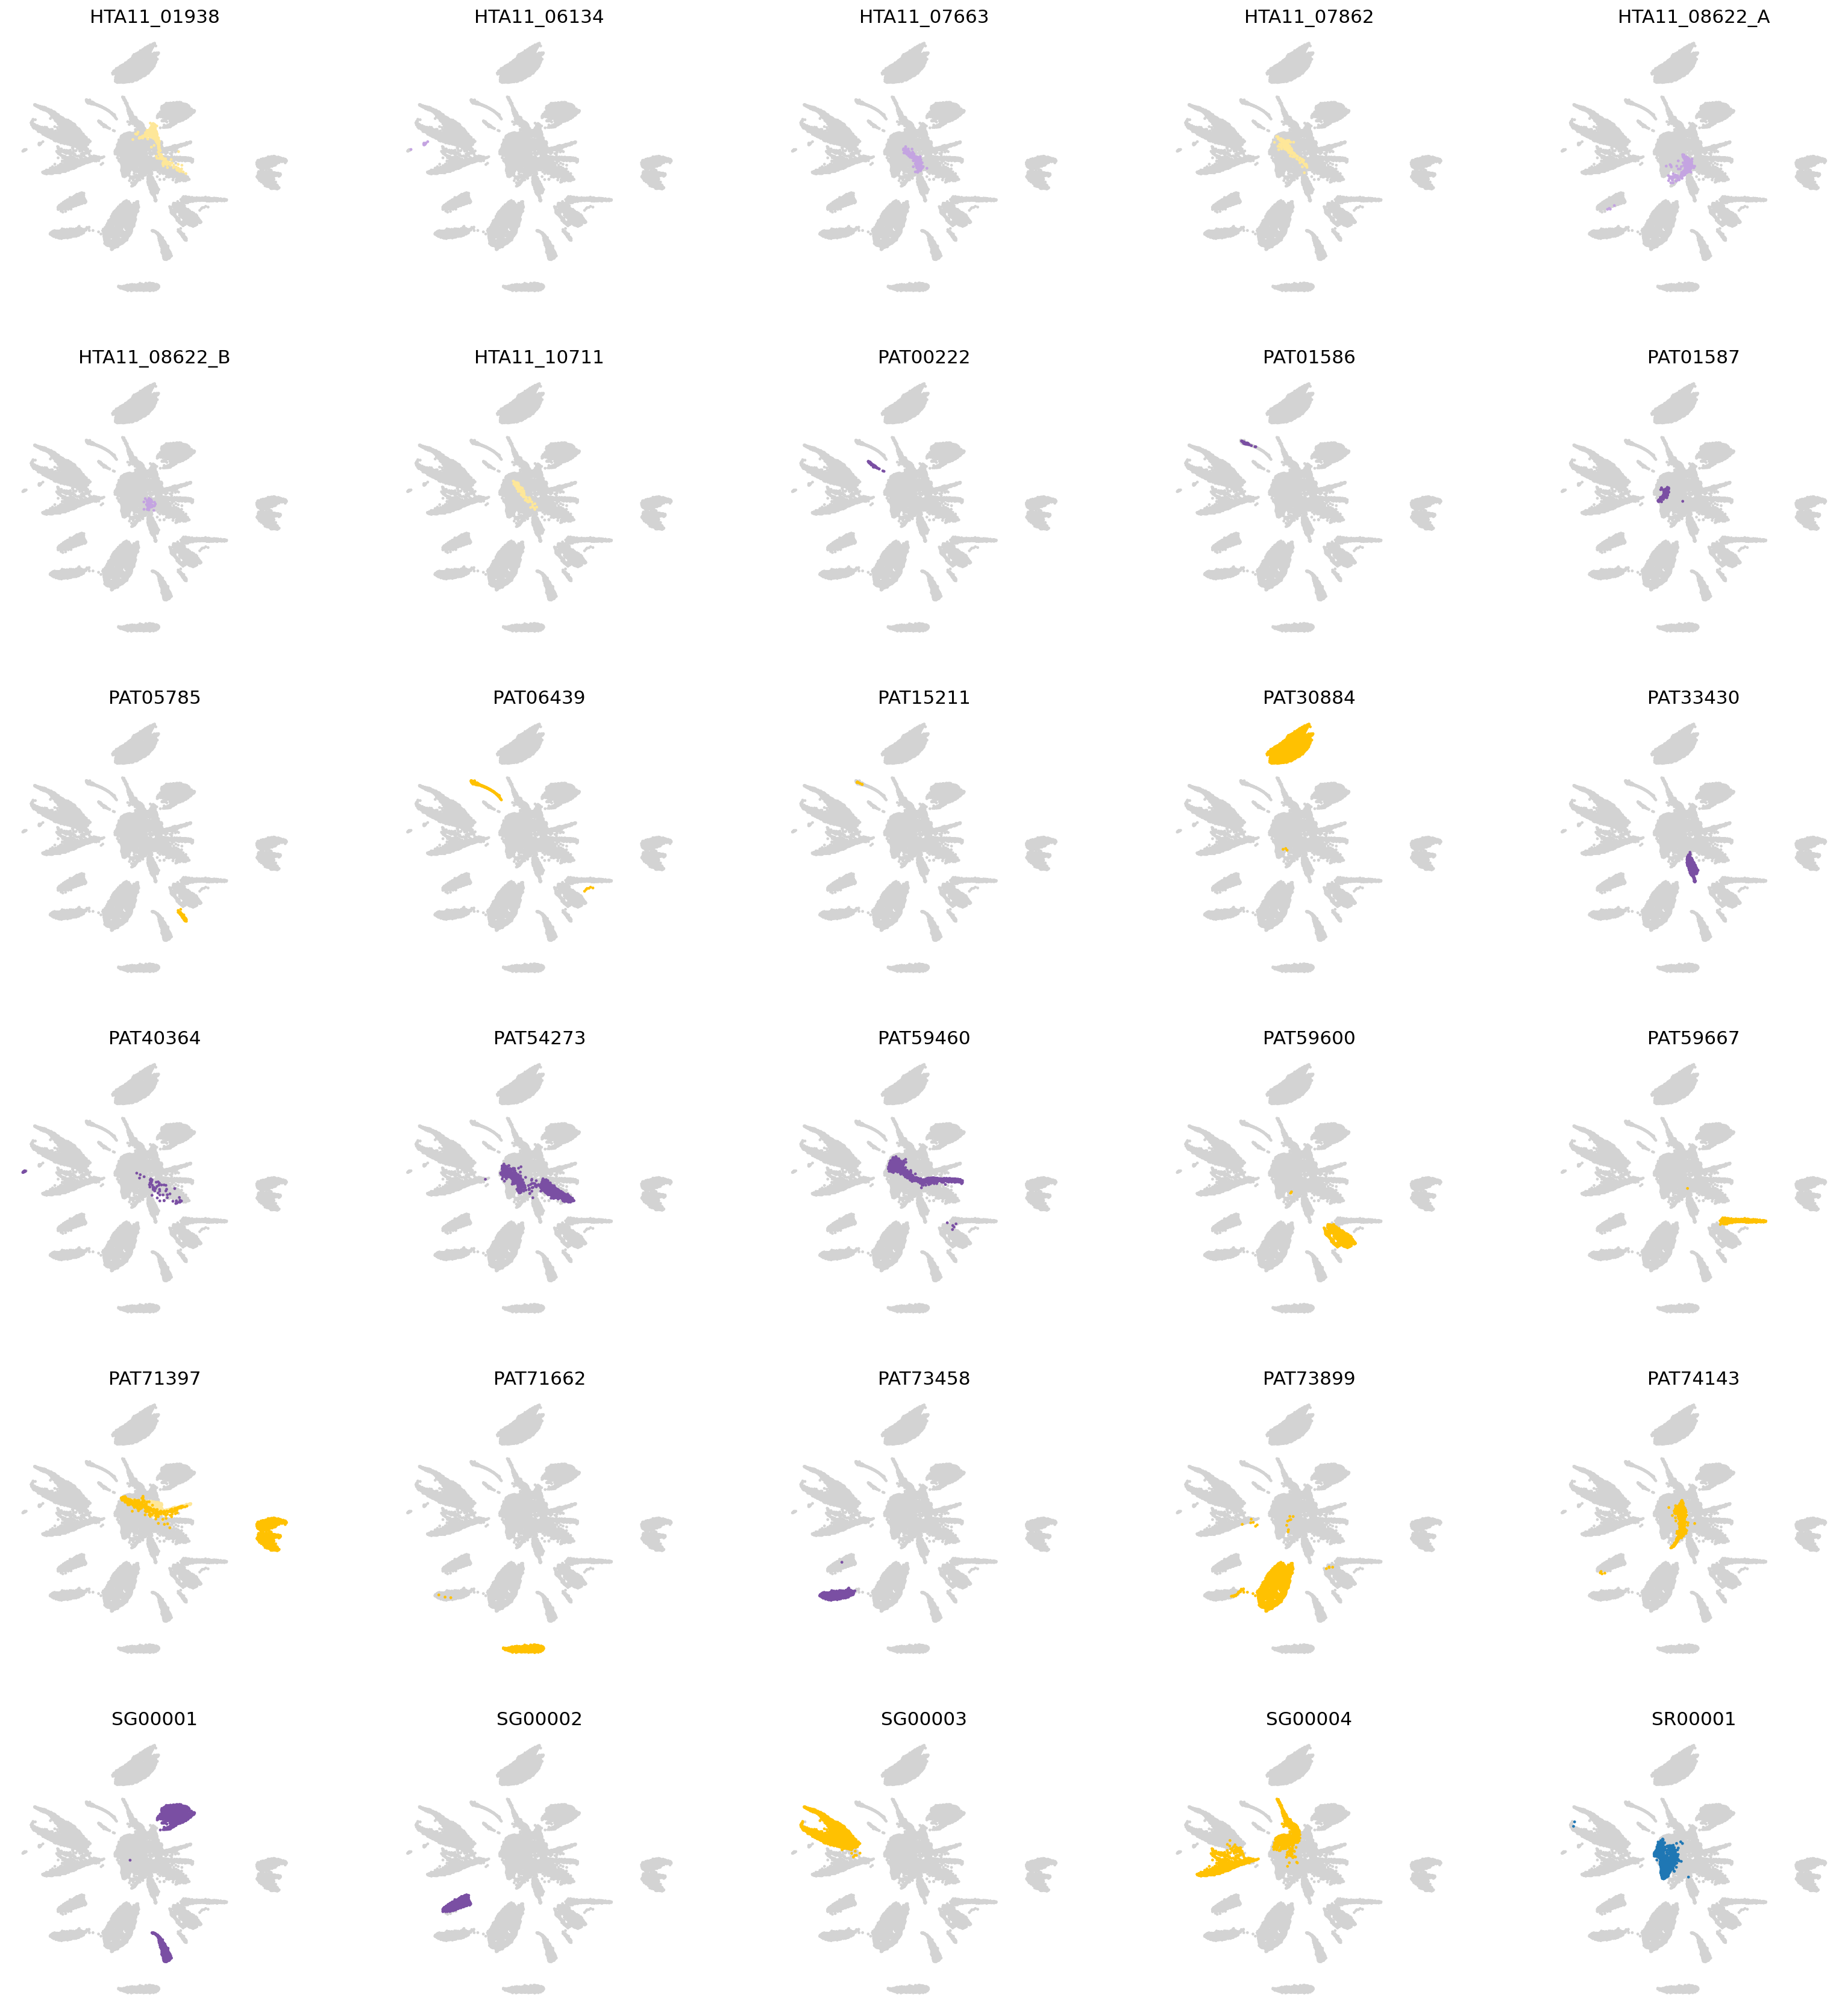

In [66]:
cnv.pl.umap(a_comb_major, color=list(a_comb_major.obs.Patient.cat.categories), ncols=5, size=18, frameon=False, legend_loc=None, save="_majorclone_patients.png")

In [73]:
a_comb_major.obs["PAT71397 CNV Score"] = a_comb_major.obs["CNV Score"].values
a_comb_major.obs.loc[a_comb_major.obs.Patient!="PAT71397", "PAT71397 CNV Score"] = np.nan

In [79]:
a_comb_major.obs["PAT71397 CNV Clone"] = a_comb_major.obs["CNV Clone"].astype(str).values
a_comb_major.obs.loc[a_comb_major.obs.Patient!="PAT71397", "PAT71397 CNV Clone"] = np.nan

In [82]:
a_comb_major.obs["PAT71397 CNV Clone"] = a_comb_major.obs["PAT71397 CNV Clone"].astype("category")
a_comb_major.uns["PAT71397 CNV Clone_colors"] = sns.color_palette("tab10", 3)

In [84]:
a_comb_major.obs["PAT71397 CNV Clone"].replace({"PAT71397 1":"1", "PAT71397 2":"2", "PAT71397 3":"3"}, inplace=True)

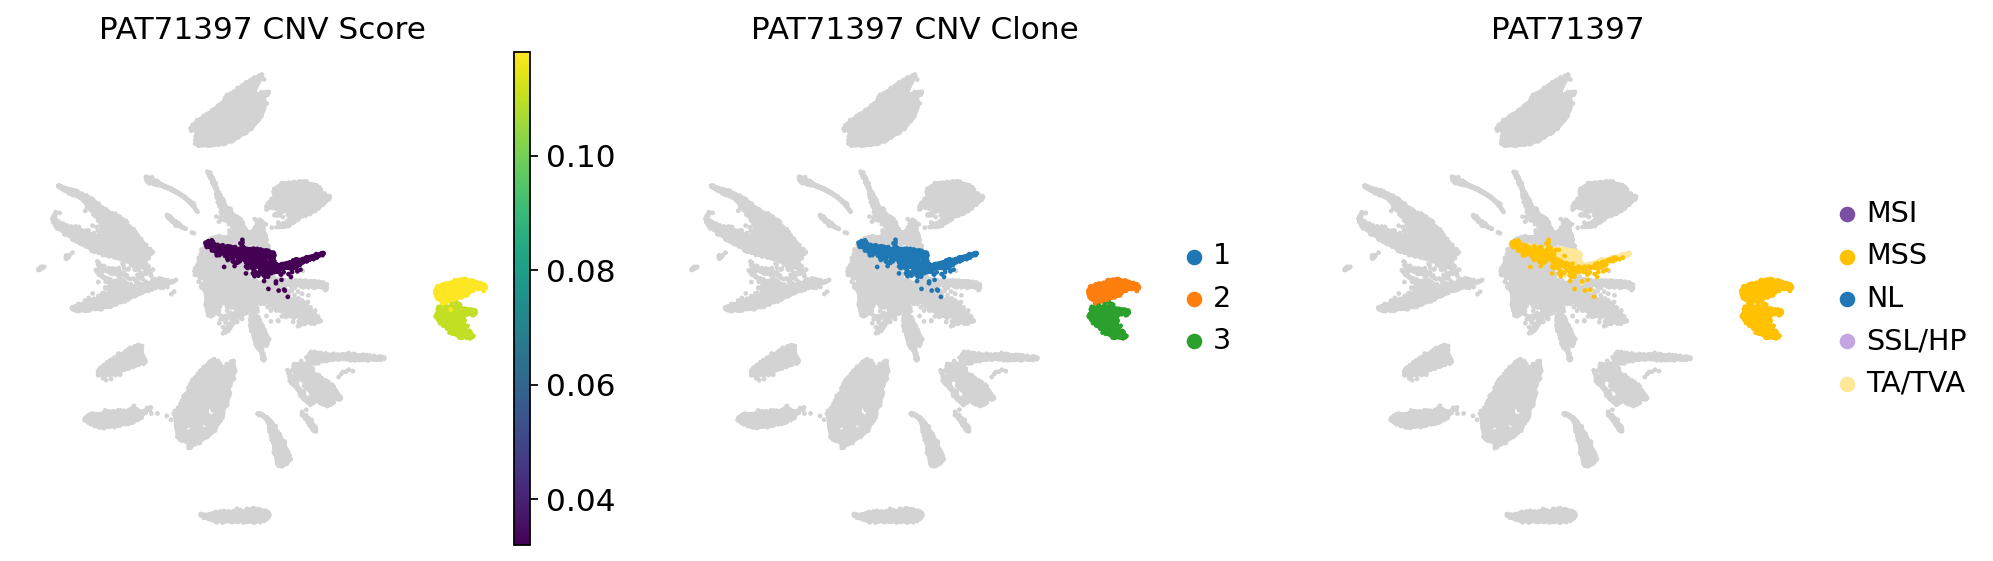

In [91]:
cnv.pl.umap(
    a_comb_major,
    color=["PAT71397 CNV Score", "PAT71397 CNV Clone", "PAT71397"],
    cmap="viridis",
    ncols=3,
    size=18,
    frameon=False,
    save="_majorclone_PAT71397.png",
    na_in_legend=False,
)

In [57]:
a_comb_major.obs["Tumor Stage"] = a_comb_major.obs["Tumor Stage"].astype("category")
a_comb_major.uns["Tumor Stage_colors"] = [cmap_dict[x] for x in a_comb_major.obs["Tumor Stage"].cat.categories]

In [58]:
a_comb_major.obs["Tumor Grade"] = a_comb_major.obs["Tumor Grade"].astype("category")
a_comb_major.uns["Tumor Grade_colors"] = [cmap_dict[x] for x in a_comb_major.obs["Tumor Grade"].cat.categories]

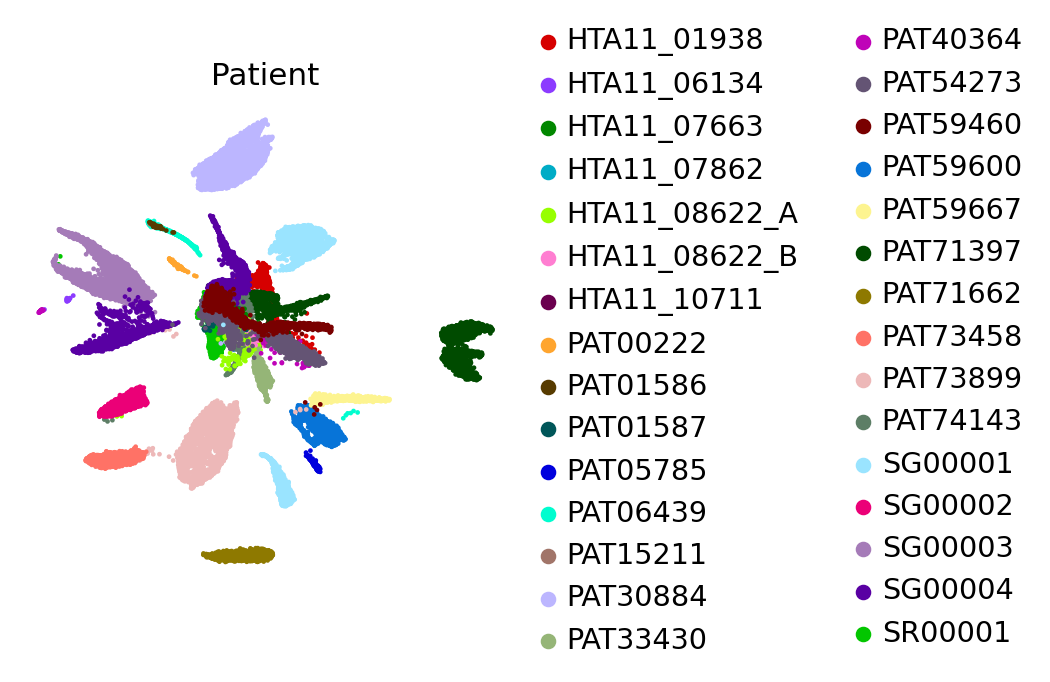

In [93]:
cnv.pl.umap(
    a_comb_major,
    color=["Patient"],
    cmap="viridis",
    ncols=1,
    size=18,
    frameon=False,
    save="_majorclone.png",
    na_in_legend=False,
)

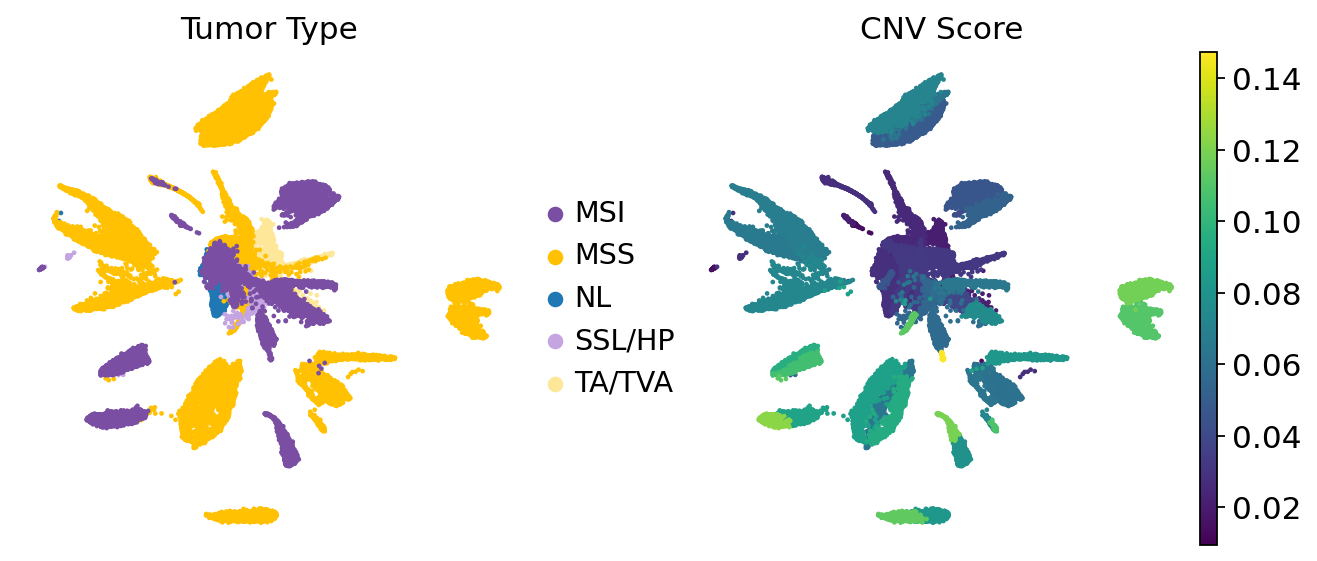

In [92]:
cnv.pl.umap(
    a_comb_major,
    color=["Tumor Type","CNV Score"],
    cmap="viridis",
    ncols=2,
    size=18,
    frameon=False,
    save="_majorclone_tumortype_score.png",
    na_in_legend=False,
)

---
# Read in scRNA data

In [8]:
a_comb = sc.read("../scRNAseq/ecotyper/VUMC/VUMC_COMBINED.h5ad"); a_comb

AnnData object with n_obs × n_vars = 22638 × 16464
    obs: 'HTAN Specimen ID', 'Cell_Type', 'Tumor_Type', 'Compartment', 'Patient'
    var: 'n_cells', 'gene_id', 'chromosome', 'start', 'end'
    obsm: 'X_pca', 'X_umap'

---
### Add CNV inference results

In [9]:
a = a_comb[a_comb.obs.Patient != "", :].copy() ; a

AnnData object with n_obs × n_vars = 6914 × 16464
    obs: 'HTAN Specimen ID', 'Cell_Type', 'Tumor_Type', 'Compartment', 'Patient'
    var: 'n_cells', 'gene_id', 'chromosome', 'start', 'end'
    obsm: 'X_pca', 'X_umap'

In [10]:
# read in CNV matrix and put in a.obsm slot
tmp = np.load("../scRNAseq/infercnv/VUMC_cnv.npz", allow_pickle="TRUE")
a.obsm["X_cnv"] = tmp.f.arr_0.item()
# read in CNV genomic partitions
a.uns["cnv"] = np.load("../scRNAseq/infercnv/uns_cnv_VUMC.npy", allow_pickle="TRUE").item()
# read in CNV score and leiden labels
tmp = pd.read_csv("../scRNAseq/infercnv/VUMC_cnv_leiden.csv", index_col=0)
a.obs = a.obs.merge(tmp, left_index=True, right_index=True)

In [11]:
a.obsm["X_cnv"], a.uns["cnv"] = remap_cnv(
    a.obsm["X_cnv"],
    a.uns["cnv"],
    [17,10,9,6,7,8,7,5,6,6,9,9,2,5,5,7,9,2,12,4,2,3],
)

chr1: orig. size = 171 - taking 1 off the top and reshaping by 10
chr2: orig. size = 109 - taking 9 off the top and reshaping by 10
chr3: orig. size = 94 - taking 4 off the top and reshaping by 10
chr4: orig. size = 65 - taking 5 off the top and reshaping by 10
chr5: orig. size = 74 - taking 4 off the top and reshaping by 10
chr6: orig. size = 88 - taking 0 off the top and reshaping by 11
chr7: orig. size = 79 - taking 2 off the top and reshaping by 11
chr8: orig. size = 57 - taking 2 off the top and reshaping by 11
chr9: orig. size = 62 - taking 2 off the top and reshaping by 10
chr10: orig. size = 64 - taking 4 off the top and reshaping by 10
chr11: orig. size = 97 - taking 7 off the top and reshaping by 10
chr12: orig. size = 90 - taking 0 off the top and reshaping by 10
chr13: orig. size = 28 - taking 0 off the top and reshaping by 14
chr14: orig. size = 52 - taking 2 off the top and reshaping by 10
chr15: orig. size = 51 - taking 1 off the top and reshaping by 10
chr16: orig. size

In [12]:
a.obs.cnv_leiden = a.obs.cnv_leiden.astype(str)
a.obs.cnv_leiden = a.obs.cnv_leiden.astype("category")

... storing 'CNV Clone' as categorical


         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: 0, 1, 10, etc.
var_group_labels: chr1, chr2, chr3, etc.


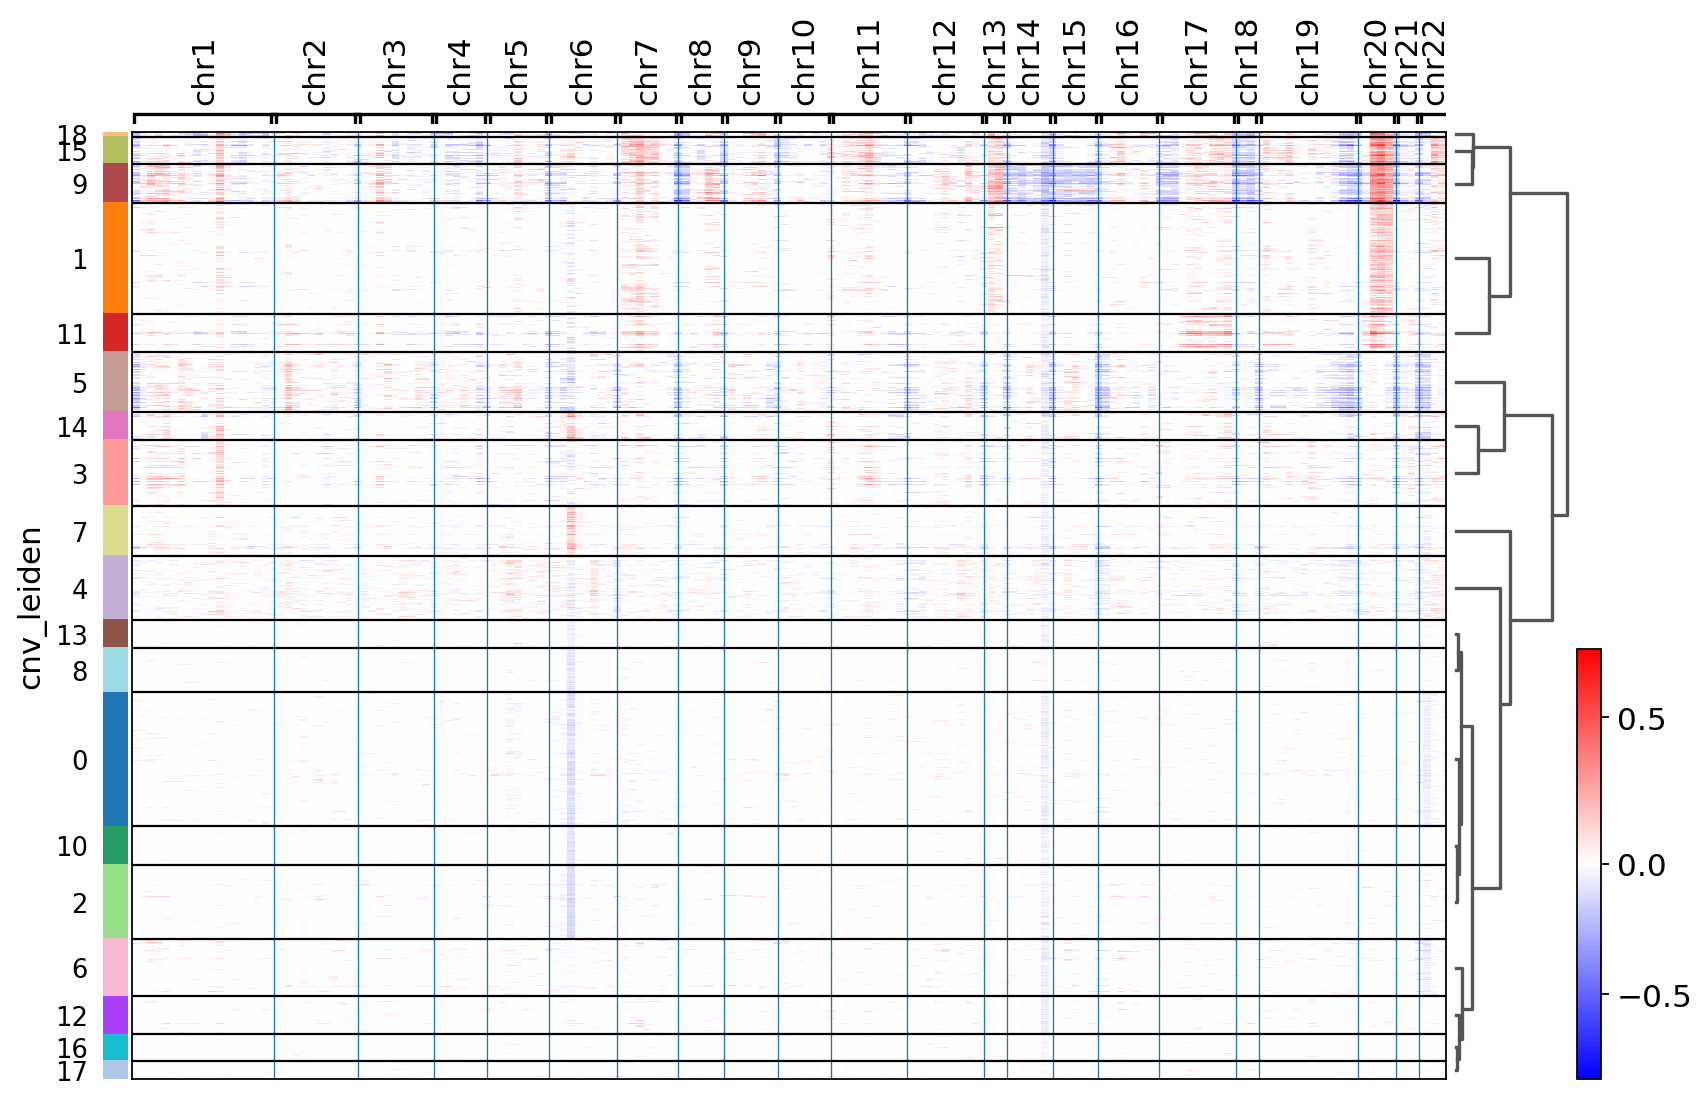

In [13]:
cnv.pl.chromosome_heatmap(
    a,
    groupby="cnv_leiden",
    save="_VUMC_leiden_remapped.png",
    dendrogram=True,
    figsize=(12,8),
)

In [14]:
# create patient colormap corresponding to tumor type
a.obs.Patient = a.obs.Patient.astype("category")
a.obs.Patient = a.obs.Patient.cat.reorder_categories(sample_order)
#a.uns["Patient_colors"] = [patient_colordict[x] for x in a.obs.Patient.cat.categories]

In [15]:
a_major = a[~(a.obs["CNV Clone"].str.contains(" E")|a.obs["CNV Clone"].str.contains(" S")),:].copy()

... storing 'CNV Clone' as categorical


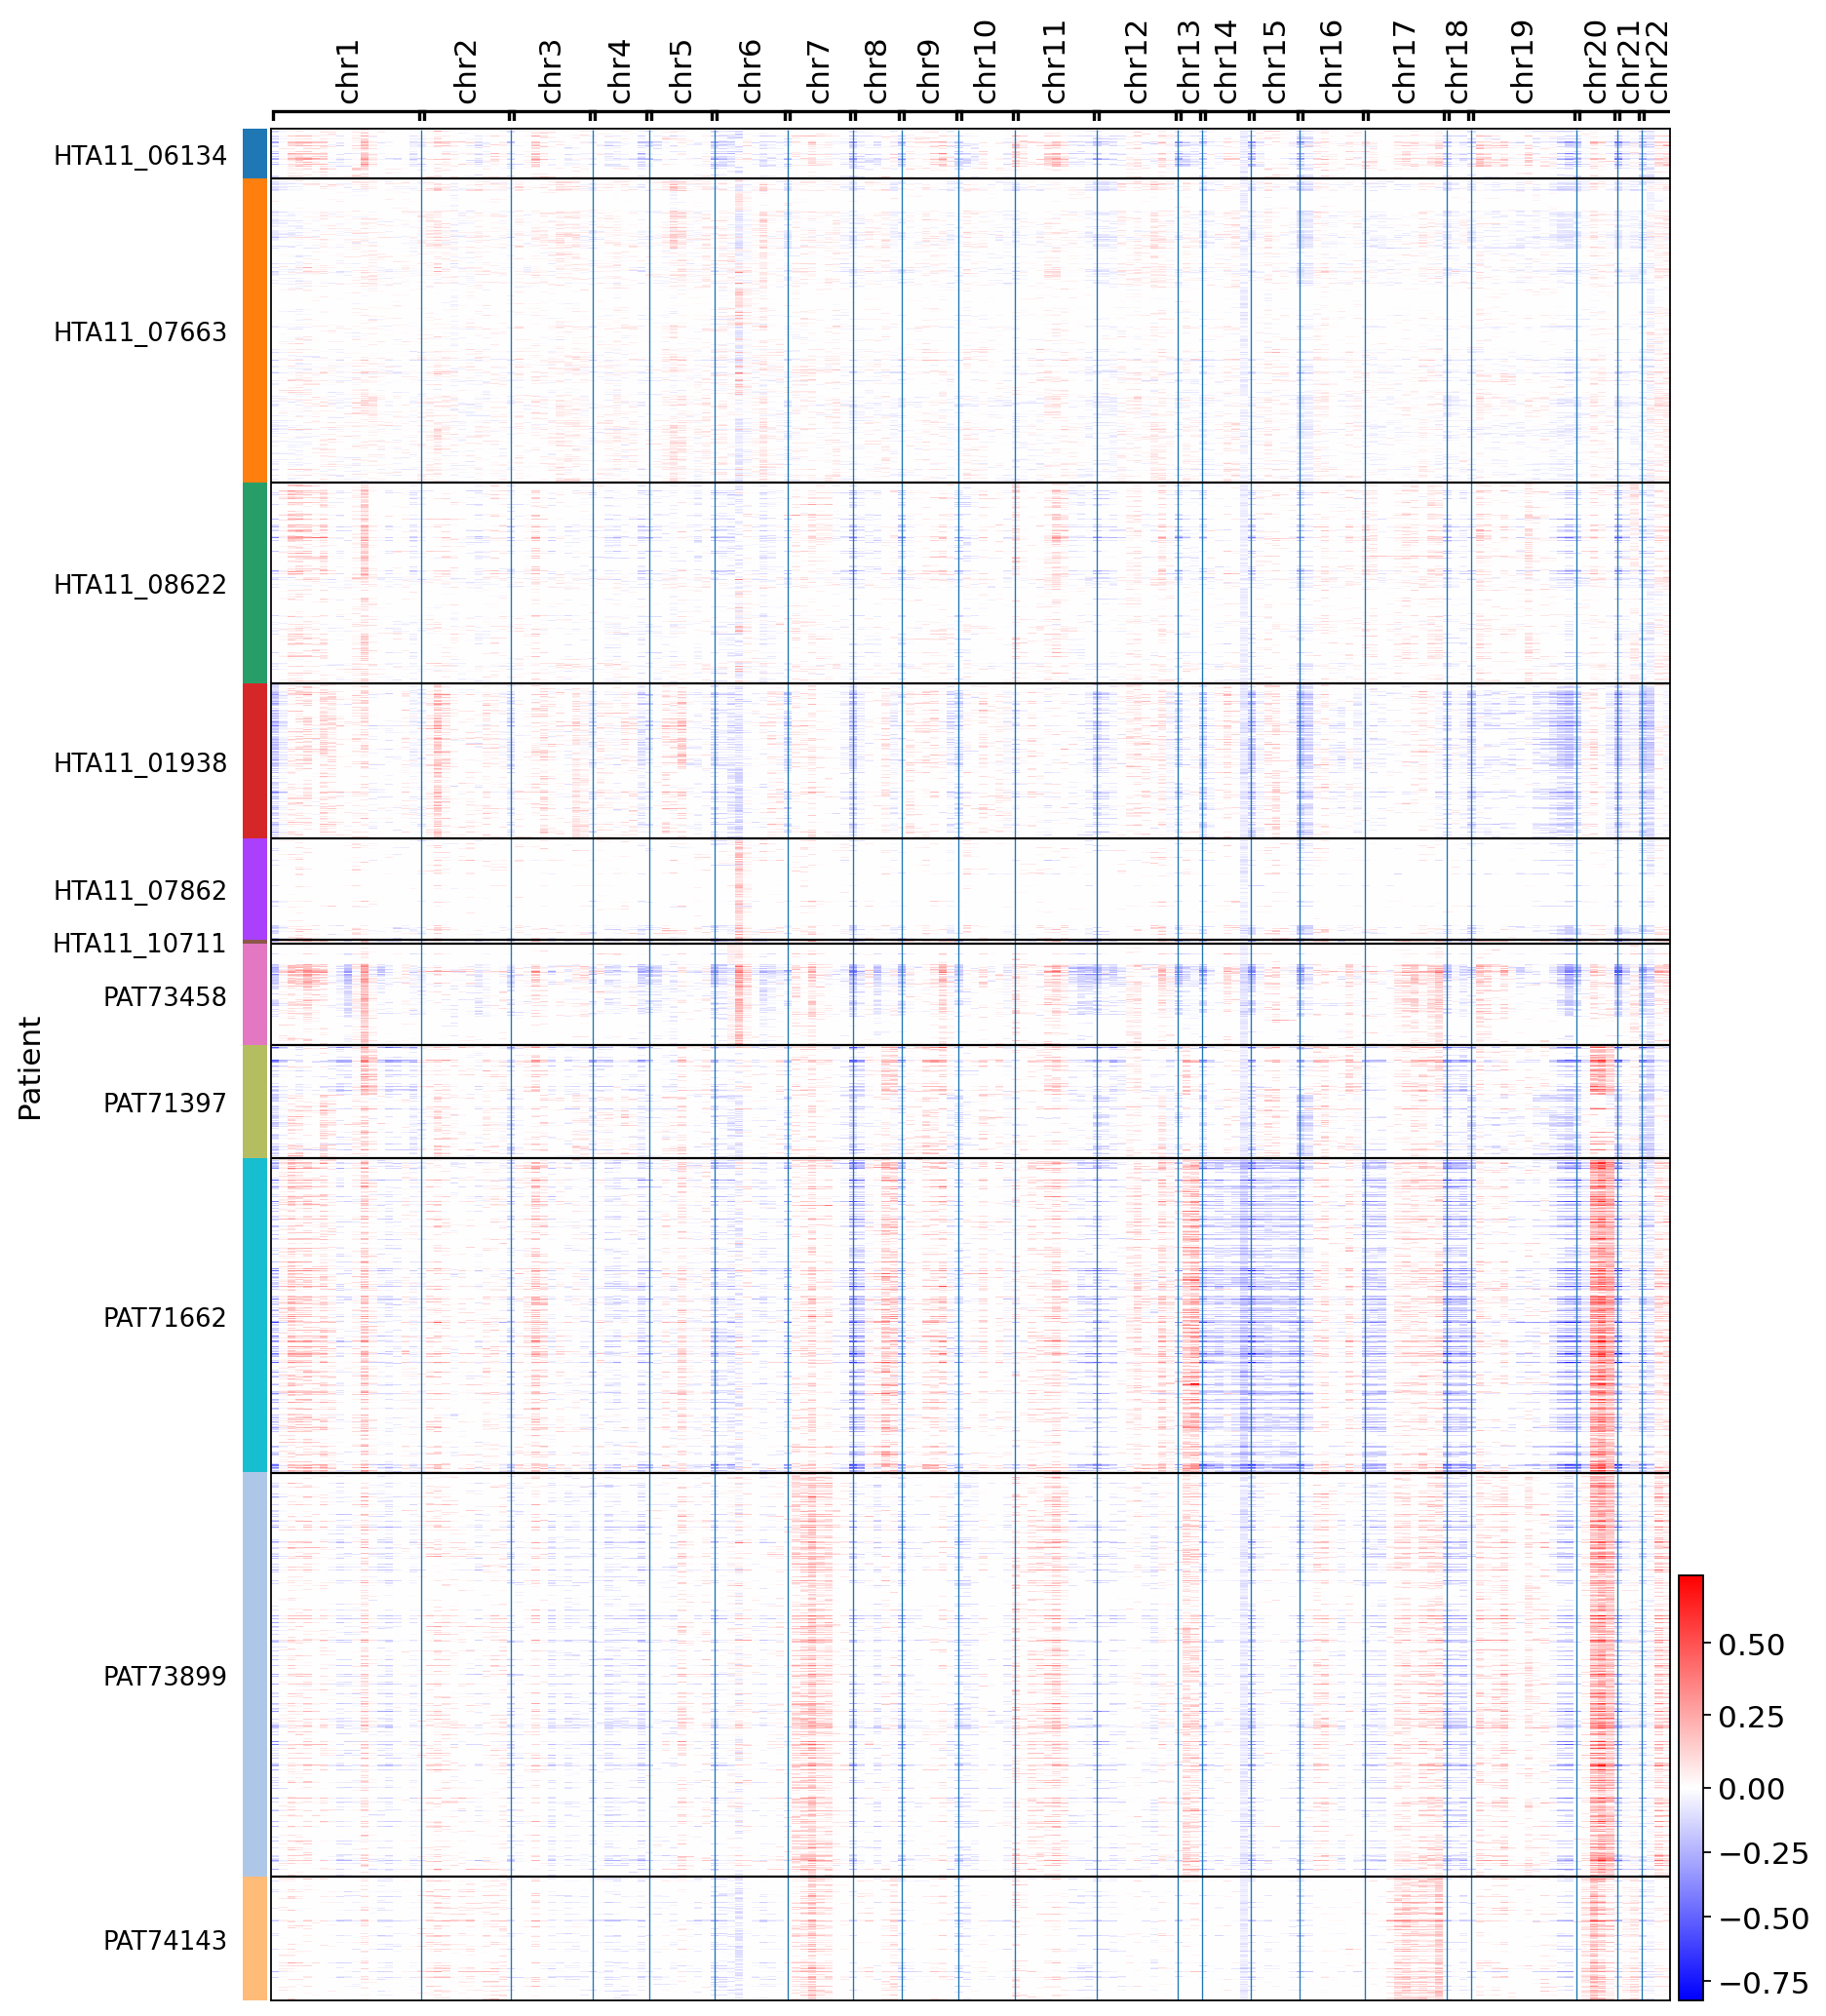

In [16]:
cnv.pl.chromosome_heatmap(
    a_major,
    groupby="Patient",
    save="_VUMC_patient_remapped.png",
    figsize=(12,16),
)

---
# Read in ST CNV samples (with matched scRNA)

In [21]:
sample_key = pd.read_csv("../../resources/visium_sample_key.csv", index_col=0)

In [22]:
outs = []
for pat in a.obs.Patient.unique():
    print(pat)
    a_comb = load_cnv(pat, sample_key=sample_key, CNV_group="patient_name")
    outs.append(a_comb)

HTA11_01938
Read adata from datasets/7319_4_HTA11_01938_master.h5ad
PAT71397
Read adata from datasets/6723_4_WD86055_master.h5ad
Read adata from datasets/6723_1_WD86056_master.h5ad
Read adata from datasets/6723_2_WD86056_master.h5ad
Read adata from datasets/6723_3_WD86056_master.h5ad
HTA11_07663
Read adata from datasets/8270_3_HTA11_07663_master.h5ad
HTA11_08622
Read adata from datasets/7319_2_HTA11_08622_A_master.h5ad
Read adata from datasets/7319_3_HTA11_08622_B_master.h5ad
PAT73899
Read adata from datasets/7003_7_WD87482_master.h5ad
Read adata from datasets/7003_8_WD87482_master.h5ad
HTA11_10711
Read adata from datasets/8270_2_HTA11_10711_master.h5ad
PAT74143
Read adata from datasets/7003_1_WD87478_master.h5ad
Read adata from datasets/7003_2_WD87478_master.h5ad
HTA11_07862
Read adata from datasets/8270_1_HTA11_07862_master.h5ad
HTA11_06134
Read adata from datasets/8270_5_HTA11_06134_master.h5ad
PAT71662
Read adata from datasets/7003_5_WD87480_master.h5ad
Read adata from datasets/700

In [23]:
for out in outs:
    out.obs.cnv_leiden = out.obs.cnv_leiden.astype(str)
    out.obs.cnv_leiden = out.obs.cnv_leiden.astype("category")
    out.obsm["X_cnv"], out.uns["cnv"] = remap_cnv(
        out.obsm["X_cnv"],
        out.uns["cnv"],
        [17,10,9,6,7,8,7,5,6,6,9,9,2,5,5,7,9,2,12,4,2,3],
    )

chr1: orig. size = 190 - taking 3 off the top and reshaping by 11
chr2: orig. size = 118 - taking 8 off the top and reshaping by 11
chr3: orig. size = 100 - taking 1 off the top and reshaping by 11
chr4: orig. size = 70 - taking 4 off the top and reshaping by 11
chr5: orig. size = 83 - taking 6 off the top and reshaping by 11
chr6: orig. size = 97 - taking 1 off the top and reshaping by 12
chr7: orig. size = 89 - taking 5 off the top and reshaping by 12
chr8: orig. size = 62 - taking 2 off the top and reshaping by 12
chr9: orig. size = 73 - taking 1 off the top and reshaping by 12
chr10: orig. size = 69 - taking 3 off the top and reshaping by 11
chr11: orig. size = 118 - taking 1 off the top and reshaping by 13
chr12: orig. size = 96 - taking 6 off the top and reshaping by 10
chr13: orig. size = 30 - taking 0 off the top and reshaping by 15
chr14: orig. size = 68 - taking 3 off the top and reshaping by 13
chr15: orig. size = 55 - taking 0 off the top and reshaping by 11
chr16: orig. si

In [24]:
%%time
# concatenate anndata objects
a_comb = outs[0].concatenate(
    outs[1:],
    join="outer",
    batch_categories=list(sample_key.index),
    fill_value=0,
)
#del a_comb.obsm
del a_comb.var

# add cnv genome partitions
a_comb.uns["cnv"] = outs[0].uns["cnv"]

# uniqueify clone names
a_comb.obs["CNV Clone"] = a_comb.obs["Patient"] + " " + a_comb.obs["CNV Clone"]

CPU times: user 6.08 s, sys: 5.01 s, total: 11.1 s
Wall time: 11.1 s


In [26]:
a_comb.obs.Patient.cat.categories

Index(['HTA11_01938', 'HTA11_06134', 'HTA11_07663', 'HTA11_07862',
       'HTA11_08622_A', 'HTA11_08622_B', 'HTA11_10711', 'PAT71397', 'PAT71662',
       'PAT73458', 'PAT73899', 'PAT74143'],
      dtype='object')

In [28]:
a_comb.obs.Patient = a_comb.obs.Patient.astype(str)
a_comb.obs.loc[a_comb.obs.Patient.isin(["HTA11_08622_A","HTA11_08622_B"]), "Patient"] = "HTA11_08622"

In [29]:
# create patient colormap corresponding to tumor type
a_comb.obs.Patient = a_comb.obs.Patient.astype("category")
a_comb.obs.Patient = a_comb.obs.Patient.cat.reorder_categories(sample_order)
#a_comb.uns["Patient_colors"] = [patient_colordict[x] for x in a_comb.obs.Patient.cat.categories]

In [30]:
# subset to major clones
a_comb_major = a_comb[
    ~(a_comb.obs["CNV Clone"].str.contains(" E")|a_comb.obs["CNV Clone"].str.contains(" S")),
    :
].copy()

... storing 'Sample' as categorical
... storing 'Block ID' as categorical
... storing 'Tumor Type' as categorical
... storing 'Tumor Location' as categorical
... storing 'Gender' as categorical
... storing 'Ethnicity' as categorical
... storing 'pathology_annotation' as categorical
... storing 'Tumor Stage' as categorical
... storing 'Tumor Grade' as categorical
... storing 'cnv_leiden' as categorical
... storing 'CNV Clone' as categorical
... storing 'MILWRM Domain' as categorical
... storing 'refNMF-MxIF MILWRM Domain' as categorical
... storing 'LCM_ROI' as categorical


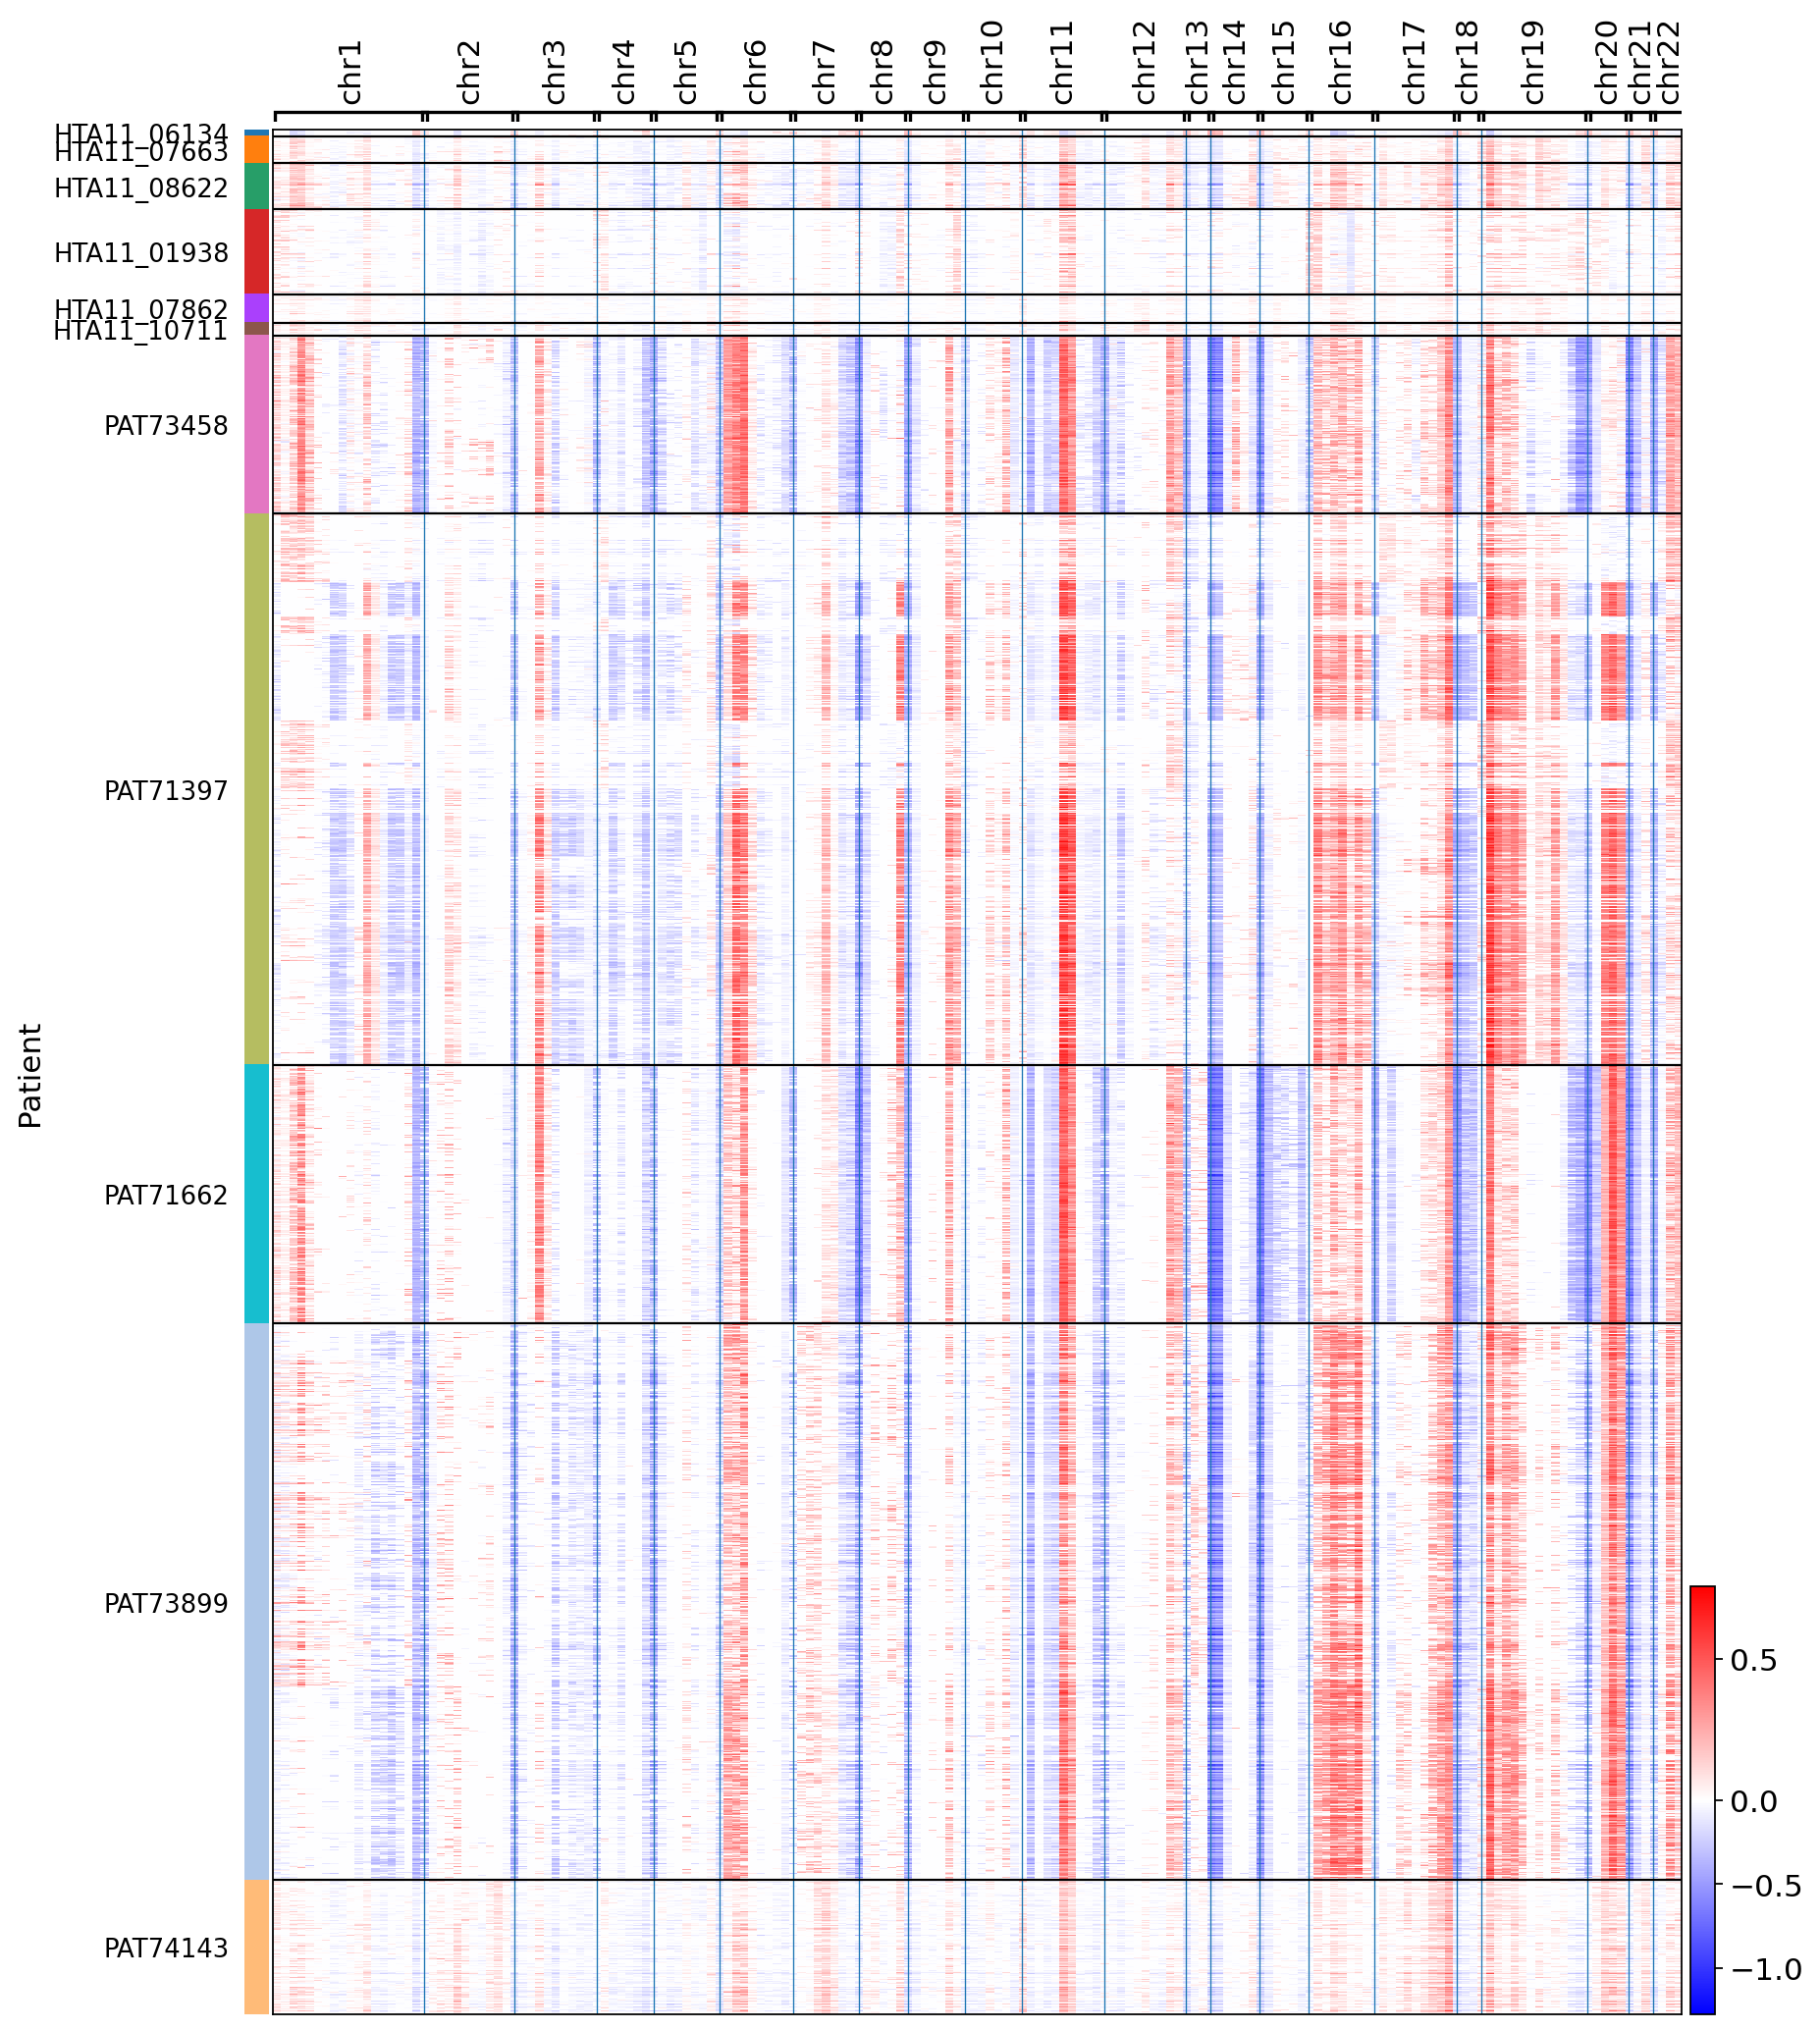

In [31]:
cnv.pl.chromosome_heatmap(
    a_comb_major,
    groupby="Patient",
    save="_ST_patient_remapped.png",
    dendrogram=False,
    figsize=(12,16),
)

---
# Distance Calculations

In [38]:
from sklearn.metrics import pairwise_distances

In [39]:
sns.set_style("white")
from matplotlib import patheffects as pe

In [40]:
dist_dict = {}
for out in outs:
    pat = out.obs.Patient.unique()[0]
    print(pat)
    print(out.shape)
    st_tmp = out[~out.obs["CNV Clone"].isin(["S","E"]),:].copy()
    print(st_tmp.shape)
    sc_tmp = a_major[a_major.obs.Patient == pat,:].copy()
    print(sc_tmp.shape)
    max_score = sc_tmp.obs.cnv_score.max()
    print("maximum scRNA CNV score: {}".format(max_score))
    sc_tmp = sc_tmp[sc_tmp.obs.cnv_score >= 0.5 * max_score,:].copy()
    print(sc_tmp.shape)
    dist_dict[pat] = 1 - pairwise_distances(X=st_tmp.obsm["X_cnv"], Y=sc_tmp.obsm["X_cnv"], metric="cosine").flatten()

HTA11_01938
(1312, 19263)
(571, 19263)
(265, 16464)
maximum scRNA CNV score: 0.022920828026641
(265, 16464)
PAT71397
(15201, 19384)
(3693, 19384)
(193, 16464)
maximum scRNA CNV score: 0.0796544637384221
(34, 16464)
HTA11_07663
(818, 19269)
(183, 19269)
(519, 16464)
maximum scRNA CNV score: 0.0151274352886877
(519, 16464)
HTA11_08622
(3061, 19335)
(305, 19335)
(344, 16464)
maximum scRNA CNV score: 0.0151274352886877
(344, 16464)
PAT73899
(7599, 19411)
(3728, 19411)
(691, 16464)
maximum scRNA CNV score: 0.0610580911873073
(201, 16464)
HTA11_10711
(665, 19207)
(84, 19207)
(8, 16464)
maximum scRNA CNV score: 0.0148919874378256
(8, 16464)
PAT74143
(5767, 19357)
(901, 19357)
(211, 16464)
maximum scRNA CNV score: 0.0153162200371118
(211, 16464)
HTA11_07862
(830, 19047)
(191, 19047)
(172, 16464)
maximum scRNA CNV score: 0.022920828026641
(30, 16464)
HTA11_06134
(229, 19150)
(42, 19150)
(85, 16464)
maximum scRNA CNV score: 0.022920828026641
(85, 16464)
PAT71662
(5794, 19417)
(1733, 19417)
(537,

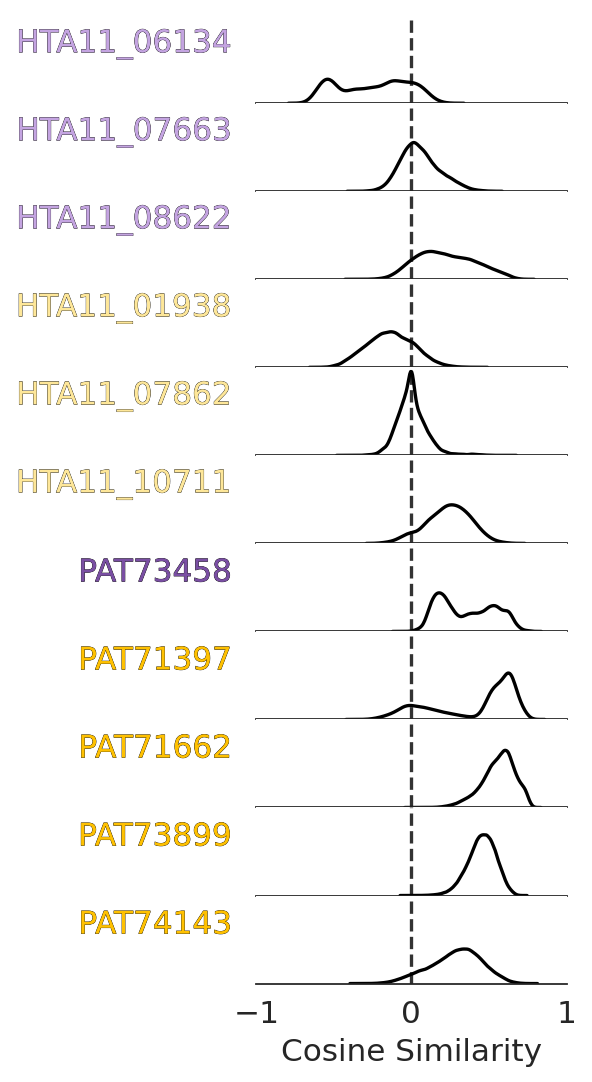

In [42]:
fig, ax = plt.subplots(len(dist_dict), 1, figsize=(4,7), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.01)
for i, title in enumerate(sample_order):
    sns.kdeplot(dist_dict[title], ax=ax[i], color="k")
    ax[i].set_ylabel(
        title,
        rotation="horizontal",
        ha="right",
        fontdict={"color":patient_colordict[title]},
        path_effects=[pe.withStroke(linewidth=0.3, foreground="k")],
    )
    ax[i].set_yticklabels([])
    ax[i].set_xlim([-1,1])
    ax[i].axvline(0.0, color="k", alpha=0.8, ls="--")
plt.xlabel("Cosine Similarity")
sns.despine(left=True)
plt.tight_layout()
fig.subplots_adjust(hspace=0)
plt.savefig("infercnv/figures/infercnv_scRNA_val_cosinesimilarity.png")